In [7]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
print()
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

260 172 3
Input size (999, 134160)


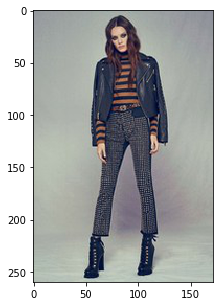

(799, 134160)


In [8]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

show_name = "Fall"
src_dir = "../img/%s" % show_name

input_files = []
for root, dirs, files in os.walk(src_dir):
    for f in files:
        if os.path.splitext(f)[-1].lower() in [".jpg", ".JPG"]:
            os.path.join(root, f)
            input_files.append(os.path.join(root, f))

tmp_image = np.array(Image.open(input_files[0]).resize((172, 260), Image.ANTIALIAS))
m, n, k = tmp_image.shape
print(m, n, k)


lwf_immatrix = []

for im in input_files[:1000]:
    image = np.array(Image.open(im))
    if np.ndim(image) == 3:
        image = np.array(Image.open(im).resize((172, 260), Image.ANTIALIAS))
        #image = (image / 255.) * 2 - 1
        image = (image / 255.)
        #image = np.pad(image, ((2, 2), (2, 2), (0, 0)), mode='constant')
        lwf_immatrix.append(image.flatten())

lwf_immatrix = np.array(lwf_immatrix)


print("Input size", lwf_immatrix.shape)

plt.figure(figsize=(5, 5))
tmp_img = lwf_immatrix[0]
plt.imshow(tmp_img.reshape(m, n, k))
plt.show()

x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(lwf_immatrix), test_size=0.20, random_state=42)

original_dim = m * n * k
print(x_train.shape)


In [9]:
input_shape = (original_dim, )
intermediate_dim = 512 #256, 512
batch_size = 20
latent_dim = 80
epochs = 40

In [10]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 134160)       0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          68690432    encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 80)           41040       dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 80)           41040       dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [15]:
"""
parser = argparse.ArgumentParser()
help_ = "Load h5 model trained weights"
parser.add_argument("-w", "--weights", help=help_)
help_ = "Use mse loss instead of binary cross entropy (default)"
parser.add_argument("-m",
                    "--mse",
                    help=help_, action='store_true')
args = parser.parse_args()
"""
models = (encoder, decoder)
data = (x_test, [0]*len(x_test))

# VAE loss = mse_loss or xent_loss + kl_loss
use_mse = False
if use_mse:
    reconstruction_loss = mse(inputs, outputs)
else:
    reconstruction_loss = binary_crossentropy(inputs,
                                              outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
#vae_loss = 0.001
print(vae_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
plot_model(vae,
           to_file='vae_mlp.png',
           show_shapes=True)

"""
if args.weights:
    vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_mlp_mnist.h5')
"""
#vae.load_weights('vae_mlp_mnist.h5')

# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp_mnist.h5')


Tensor("Mean_11:0", shape=(), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 134160)            0         
_________________________________________________________________
encoder (Model)              [(None, 80), (None, 80),  68772512  
_________________________________________________________________
decoder (Model)              (None, 134160)            68865552  
Total params: 137,638,064
Trainable params: 137,638,064
Non-trainable params: 0
_________________________________________________________________
Train on 799 samples, validate on 200 samples
Epoch 1/40
140/799 [====>.........................] - ETA: 3:35 - loss: nan

KeyboardInterrupt: 

In [ ]:
decoder.summary()

In [ ]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [ ]:
# display a 2D manifold of the digits
n = 4  # figure with 15x15 digits
#digit_size = 28
figure = np.zeros((width * n, height * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)


print(grid_x)
print(grid_y)
print(figure)

z_sample = np.array([[3, 5]]) * 1
#x_decoded = decoder.predict(z_sample)

plt.figure(figsize=(10, 10))
"""
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = decoder.predict(z_sample)
        plt.imshow(x_decoded[0].reshape(width, height))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
"""

plt.show()


In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
#digit_size = 28
figure = np.zeros((width * n, height * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1
        x_decoded = decoder.predict(z_sample)
        img = x_decoded[0].reshape(width, height)
        figure[i * width: (i + 1) * width,
               j * height: (j + 1) * height] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()